# Analysis Sample

In [1]:
from pathlib import Path
import PIL
from ufish.api import UFish
from cellpose import models
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
from skimage.morphology import diamond, ball, dilation, square
from functools import reduce
from skimage.segmentation import watershed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os


In [2]:
# Cancer pathology samples
data_dir = "./data/"
img_paths = {
    path.stem: path for path in Path(data_dir).glob("*.TIF")
}

print(img_paths)

images = {
    name: np.array(PIL.Image.open(path))
    for name, path in img_paths.items()
}

{'Dual fusion': PosixPath('data/Dual fusion.TIF'), 'separation probe': PosixPath('data/separation probe.TIF'), 'Trisomy 8': PosixPath('data/Trisomy 8.TIF')}


In [288]:
# initialize cellpose model
cp = models.Cellpose(gpu=False, model_type="nuclei")

def segment_cells(img, ch=-1, area_threshold=1000, centroid_distance_threshold=95, 
                  axis_ratio_threshold=0.9):
    """Segment cells using cellpose model and remove masks based on centroid distance and axis ratio."""
    img = img[:, :, ch]
    masks, _, _, _ = cp.eval(img, diameter=50, flow_threshold=1.2, cellprob_threshold=1)
    masks = remove_small_objects(masks, min_size=1000)
    labeled_masks = label(masks)
    props = regionprops(labeled_masks)
    centroids = np.array([prop.centroid for prop in props])
    distances = cdist(centroids, centroids)
    for i in range(len(props)):
        if props[i].area > area_threshold:
            axis_ratio = props[i].minor_axis_length / props[i].major_axis_length
            distances_to_other_centroids = distances[i, :]
            distances_to_other_centroids[i] = np.inf
            if np.min(distances_to_other_centroids) < centroid_distance_threshold or axis_ratio < axis_ratio_threshold:
                masks[labeled_masks == props[i].label] = 0
    return masks

import cv2
import numpy as np

def extract_cell_rois(image, masks, min_area):
    cell_rois = []
    cell_masks = []

    for ch in range(image.shape[2]):
        ch_image = image[:, :, ch]
        binary_mask = (masks > 0).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        channel_cell_rois = []
        channel_cell_masks = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cell_roi = ch_image[y:y+h, x:x+w]
            cell_mask = binary_mask[y:y+h, x:x+w]
            
            mask_area = np.sum(cell_mask)

            if mask_area > min_area:
                scale_factor = min(128 / h, 128 / w)
                if scale_factor < 1:
                    new_w, new_h = int(w * scale_factor), int(h * scale_factor)
                    cell_roi = cv2.resize(cell_roi, (new_w, new_h))
                    cell_mask = cv2.resize(cell_mask, (new_w, new_h))
                    w, h = new_w, new_h

                padded_roi = np.zeros((128, 128), dtype=ch_image.dtype)
                padded_mask = np.zeros((128, 128), dtype=binary_mask.dtype)

                start_y = (128 - h) // 2
                start_x = (128 - w) // 2

                padded_roi[start_y:start_y+h, start_x:start_x+w] = cell_roi
                padded_mask[start_y:start_y+h, start_x:start_x+w] = cell_mask

                channel_cell_rois.append(padded_roi)
                if ch == image.shape[2] - 1: 
                    channel_cell_masks.append(padded_mask)
        
        cell_rois.append(channel_cell_rois)
        if ch == image.shape[2] - 1: 
            cell_masks = channel_cell_masks

    return np.array(cell_rois), np.array(cell_masks)


def cc_sub(im: np.ndarray, seed: np.ndarray, connectivity=2) -> np.ndarray:
    """Subtract the Connected Components in image which overlap with seed.

    :param im: mask image to be subtract CC.
    :param seed: mask image.
    :param connectivity: connectivity to calculate label, see:
    https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

    :return: CC in im without overlap with seed.
    """
    lb = label(seed, connectivity=connectivity)
    w = watershed(im, markers=lb, connectivity=connectivity, mask=im)
    o = w > 0
    d = im ^ o
    return d

def mask_sub(oriangal: np.ndarray,
             masks: list[np.ndarray],
             ) -> np.ndarray:
    o = oriangal
    for m in masks:
        o = cc_sub(o, m)
    return o

def coordinates_to_mask(points: np.ndarray, shape: tuple or None = None) -> np.ndarray:
    points = points.astype(np.int64)
    dim_max = tuple([points[:, i].max()+1 for i in range(points.shape[1])])
    if shape is None:
        shape = dim_max
    else:
        assert len(shape) == points.shape[1]
        shape = tuple([shape[i] or dim_max[i] for i in range(points.shape[1])])
    arr = np.zeros(shape, dtype=np.bool_)
    ix = tuple(points[:, d] for d in range(points.shape[1]))
    arr[ix] = True  
    return arr

def cc_centroids(mask: np.ndarray) -> np.ndarray:
    if mask.dtype == bool:
        mask = label(mask.astype(int)) 
    ccs = regionprops(mask)
    centroids, labels = [], []
    for cc in ccs:
        centroids.append(cc.centroid)
        labels.append(cc.label)
    return np.array(centroids), np.array(labels)

def spots_sub(spots_a: np.ndarray, spots_b: np.ndarray, radius: int):
    assert spots_a.shape[1] == spots_b.shape[1]
    dim = spots_a.shape[1]
    assert 2 <= dim <= 3
    shape = tuple([max([int(pts[:, i].max()) for pts in [spots_a, spots_b]]) + 1
                   for i in range(dim)])
    mask_a = coordinates_to_mask(spots_a, shape)
    se = diamond(radius) if dim == 2 else ball(radius)
    mask_a = dilation(mask_a, se)
    mask_b = coordinates_to_mask(spots_b, shape)
    res_mask = mask_sub(mask_a, [mask_b])
    return cc_centroids(res_mask)[0]


# initialize ufish model
uf = UFish()
uf.load_weights("./v1.0.1-DNAFISH_model.pth")
# weights link: https://huggingface.co/GangCaoLab/U-FISH/blob/main/finetune_models/v1.0.1-DNAFISH_model.pth

def call_spots(img, ch=[0, 1], intensity_threshold=0.5):
    """Call spots using ufish model."""
    spots_list = []
    for c in ch:
        spots, _ = uf.predict(img[:, :, c])
        spots = spots.values
        spots = spots[img[spots[:, 0], spots[:, 1], c] > intensity_threshold]
        spots_list.append(spots)
    return spots_list

def get_merge_spots(spots_list, max_dist=2.0, ch=[0, 1]):
    """Get the coordinates of all merged spots from multiple channels."""
    spots_ch1 = spots_list[ch[0]]
    spots_ch2 = spots_list[ch[1]]
    tree = KDTree(spots_ch1)
    dist, ind = tree.query(spots_ch2, k=1)
    merge_spots = spots_ch1[ind[dist < max_dist]]
    if len(ch) == 3:
        spots_ch3 = spots_list[ch[2]]
        tree = KDTree(merge_spots)
        dist, ind = tree.query(spots_ch3, k=1)
        merge_spots = merge_spots[ind[dist < max_dist]]
    return merge_spots

def assign_spots(
        spots: np.ndarray,
        mask: np.ndarray,
        dist_th: float,
        ) -> np.ndarray:
    assert len(mask.shape) in (2, 3)
    centers, labels = cc_centroids(mask)
    assert centers.shape[1] == len(mask.shape)
    pos_each_axes = np.where(mask > 0)
    pos_ = np.c_[pos_each_axes]
    tree = KDTree(pos_)
    dist, idx = tree.query(spots)
    dist, idx = np.concatenate(dist), np.concatenate(idx)
    clost = pos_[idx, :]
    if centers.shape[1] == 2:
        mask_val = mask[clost[:, 0], clost[:, 1]]
    else:
        mask_val = mask[clost[:, 0], clost[:, 1], clost[:, 2]]
    res = mask_val
    res[dist > dist_th] = 0
    return res    
   
def change_ch(img):
    tmp = np.swapaxes(img,0, 1)
    tmp = np.swapaxes(tmp,1, 3)
    tmp = np.swapaxes(tmp,1, 2)
    return tmp

def plot_cell_and_spots(img, mask, signals, colors, number):

    fig, ax = plt.subplots(1, 2, figsize=(6, 3)) 
    
    ax[0].imshow(img)
    ax[0].axis("off")
    
    bmask = mask > 0
    edges = dilation(bmask > 0, diamond(1)) & ~bmask
    img_spots = img.copy()
    img_spots[edges] = 200 
    ax[1].imshow(img_spots)
    ax[1].axis("off")

    for name, spot in signals.items():
        if len(spot) > 0:  # check if there are spots
            ax[1].scatter(spot[:, 1], spot[:, 0], s=20, edgecolors='none', c=colors[name], label=name)
    
    channel_counts = [len(signals[channel]) for channel in signals.keys()]

    text_colors = [colors[channel] for channel in signals.keys()]
 
    text_items = [f"{count}" for _, count in zip(signals.keys(), channel_counts)]
    
    for i, (text, color) in enumerate(zip(text_items, text_colors)):
        fig.text(-0.1 + 0.1 * i, 0.15, text, color=color, fontsize=25, alpha=0.8, transform=ax[1].transAxes, ha='center', va='top')
    
    fig.text(0.03, 0.97, str(number), color='white', fontsize=30, alpha=1, transform=ax[0].transAxes, ha='left', va='top')
    
    fig.tight_layout(pad=0) 
    return fig

def plot_all_rois(rois, masks, signals, colors):
    num_plots = len(rois)
    rows = int(np.ceil(num_plots / 5))
    cols = min(5, num_plots)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3*rows), facecolor='k')

    for i, (ax, roi, mask, signal) in enumerate(zip(axs.flat, rois, masks, signals)):
        n = i+1
        bmask = mask > 0
        edges = dilation(bmask>0, diamond(1)) & ~bmask
        img = roi.copy()
        img[edges, :] = 255
        ax.imshow(img)

        for name, spot in signal.items():
            if name in colors and len(spot) > 0:
                ax.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)

        channel_names = list(signal.keys())
        channel_counts = [len(signal[channel]) for channel in channel_names]
        text_colors = [colors.get(channel, 'white') for channel in channel_names]
        text_items = [f"{count}" for count in channel_counts]

        for i, (text, color) in enumerate(zip(text_items, text_colors)):
            ax.text(0.05 + 0.1 * i, 0.12, text, color=color, fontsize=20, alpha=0.8, transform=ax.transAxes, ha='center', va='top')

        ax.text(0.03, 0.97, str(n), color='white', fontsize=25, alpha=1, transform=ax.transAxes, ha='left', va='top')
        ax.axis("off")

    for ax in axs.flat[num_plots:]:
        ax.set_facecolor('k')
        ax.axis('off')

    plt.tight_layout()
    return fig
        
from shutil import rmtree
def plot_figs(cell_rois, cell_masks, cell_signals, res_dir):
    fig_dir = f"{res_dir}/figures"
    if os.path.exists(fig_dir):
        rmtree(f"./{fig_dir}")
    os.mkdir(f"./{fig_dir}")
    for w in range(cell_rois.shape[0]):
        fig = plot_cell_and_spots(cell_rois[w], cell_masks[w], cell_signals[w],  colors={"ch1": "hotpink", "ch2": "lime", "ch1+ch2": "yellow"}, number=w+1)
        plt.text(50, -5, f"cell-{w+1}", fontsize=12)
        fig.savefig(f"{fig_dir}/cell-{w+1}.pdf")
        plt.close(fig)

def extract_signal_mask(cell_im_ch, cell_spots, quantile=25, square_size=3):
    mask = np.zeros_like(cell_im_ch)
    mask[cell_spots[:, 0], cell_spots[:, 1]] = 1
    mask = dilation(mask, square(square_size))
    signals = cell_im_ch[mask > 0]
    threshold = np.percentile(signals, quantile)
    signal_mask = cell_im_ch > threshold
    return signal_mask

def get_merge_and_split_masks(cell_im, channels, quantile=25, square_size=3):
    signal_masks = {}  # signal masks for each channel

    for ch in channels:
        cell_spots = call_spots(cell_im, ch=[ch], intensity_threshold=0.3)[0]
        cell_im_ch =  cell_im[:, :, ch]
        if len(cell_spots) == 0:
            return None, None, None
        signal_mask = extract_signal_mask(cell_im_ch, cell_spots, quantile=quantile, square_size=square_size)
        signal_masks[ch] = signal_mask

    #merge_mask = signal_masks[0] & signal_masks[1] # merge mask
    merge_mask = reduce(lambda x, y: x & y, signal_masks.values())
    signal_masks_sub = {}  # signal masks for each channel after subtracting merged mask

    # remove connected components which with overlap with the merged 
    for ch in channels:
        ch_sig_mask = signal_masks[ch]
        signal_masks_sub[ch] = mask_sub(ch_sig_mask, [merge_mask])
    return merge_mask, signal_masks, signal_masks_sub

def keep_largest_area_label(mask):

    unique_labels = np.unique(mask)
    num_labels = len(unique_labels)

    if num_labels == 1:
        return mask
    
    regions = regionprops(label(mask))

    largest_region = max(regions, key=lambda region: region.area)
    largest_label = largest_region.label

    new_mask = np.zeros_like(mask)
    new_mask[label(mask) == largest_label] = 1

    return new_mask

def pipeline(img, signal_channels=[0, 1]):
    print(f"Processing image:")
    print(f"Image shape: {img.shape}")
    print("Step 1: segment cells")
    masks = segment_cells(img)

    print("Step 2: extract ROIs")
    cell_rois, cell_masks = extract_cell_rois(img, masks, 10)
    cell_masks = [keep_largest_area_label(cell_masks[i]) for i in range(cell_masks.shape[0])]

    print("Step 3: call spots and assign spots")
    table = []
    cell_signals = []
    cell_rois = change_ch(cell_rois)
    for w in range(cell_rois.shape[0]):
        signals = {}
        for ch in signal_channels:
            signals[f"ch{ch+1}"] = []
        name = "+".join([f"ch{ch+1}" for ch in signal_channels])
        signals[name] = []
        merge_mask, signal_masks, signal_masks_sub = get_merge_and_split_masks(cell_rois[w], signal_channels, quantile=20, square_size=4)
        if signal_masks is None:
            for ch in signal_channels:
                signals[f"ch{ch+1}"] = []
            name = "+".join([f"ch{ch+1}" for ch in signal_channels])
            signals[name] = []
        else:
            for ch in signal_channels:
                single_ch = regionprops(label(signal_masks_sub[ch]))
                spots = np.array([cc.centroid for cc in single_ch])
                signals[f"ch{ch+1}"] = spots

            merged = regionprops(label(merge_mask))
            spots = np.array([cc.centroid for cc in merged])
            name = "+".join([f"ch{ch+1}" for ch in signal_channels])
            signals[name] = spots

        assigns = {}
        for name, spots in signals.items():
            try:
                assigns[name] = assign_spots(spots, cell_masks[w], 30)
            except Exception:
                assigns[name] = []

        df = {key: sum(value) for key, value in assigns.items() if isinstance(value, np.ndarray)} 
        df["cell_id"] = f'{w+1}'
        last_key = list(df.keys())[-1]
        last_value = df.pop(last_key)
        df = {last_key: last_value, **df}
        table.append(df)
        cell_signals.append(signals)
          
    return pd.DataFrame(table).fillna(0), cell_rois, cell_masks, cell_signals

2024-04-10 18:22:24.435 | INFO     | ufish.api:init_model:70 - Initializing ufish model with kwargs: {}
2024-04-10 18:22:24.436 | INFO     | ufish.api:init_model:72 - Number of parameters: 162959
2024-04-10 18:22:24.457 | INFO     | ufish.api:init_model:78 - CUDA is available, using GPU.
2024-04-10 18:22:24.458 | INFO     | ufish.api:_load_pth_file:232 - Loading weights from ./v1.0.1-DNAFISH_model.pth


In [289]:
from shutil import rmtree
import os
main_dir = "results"
os.makedirs(main_dir, exist_ok=True)
for name, img in images.items():
    print(name)
    res_dir = f"./{main_dir}/{name}"
    if os.path.exists(res_dir):
        rmtree(f"./{res_dir}")
    os.mkdir(f"./{res_dir}")

    if name.startswith("Trisomy"):
        signal_channels=[0]
    else:
        signal_channels=[0, 1]
    table, rois, masks, signals= pipeline(img, signal_channels=signal_channels)

    plot_figs(rois, masks, signals, res_dir)

    fig = plot_all_rois(rois, masks, signals, colors={"ch1": "hotpink", "ch2": "lime", "ch1+ch2": "yellow"})
    fig.savefig(f"{res_dir}/{name}_all_cells.pdf")
    plt.close(fig)

    table.to_csv(f"{res_dir}/{name}_results.csv", index=False)

Dual fusion
Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-04-10 18:23:54.826 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.827 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.858 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.859 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.874 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.875 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.884 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.885 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)


Step 2: extract ROIs
Step 3: call spots and assign spots


2024-04-10 18:23:54.903 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.904 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.913 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.914 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.929 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.930 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.938 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.939 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:23:54.955 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:23:54.956 | INFO     | ufish.api:p

separation probe
Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-04-10 18:25:19.095 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.097 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.128 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.129 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.148 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.149 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.157 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.158 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.177 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.178 | INFO     | ufish.api:p

Step 2: extract ROIs
Step 3: call spots and assign spots


2024-04-10 18:25:19.215 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.216 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.232 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.232 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.241 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.242 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.260 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.260 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:25:19.269 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:25:19.270 | INFO     | ufish.api:p

Trisomy 8
Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-04-10 18:26:34.504 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.505 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.538 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.539 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.550 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.551 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.562 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.562 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.573 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.574 | INFO     | ufish.api:p

Step 2: extract ROIs
Step 3: call spots and assign spots


2024-04-10 18:26:34.598 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.599 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.609 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.610 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.621 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.622 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.632 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.633 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 18:26:34.645 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 18:26:34.646 | INFO     | ufish.api:p

In [217]:
# test
img = images["separation probe"]

table, rois, masks, signals = pipeline(img, signal_channels=[0, 1])

Processing image:
Image shape: (3000, 4096, 3)
Step 1: segment cells


2024-04-10 16:43:03.001 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.003 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.033 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.034 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.053 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.054 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.063 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.063 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.083 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.084 | INFO     | ufish.api:p

Step 2: extract ROIs
Step 3: call spots and assign spots


2024-04-10 16:43:03.112 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.113 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.122 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.122 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.138 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.139 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.147 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.148 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-04-10 16:43:03.166 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-04-10 16:43:03.167 | INFO     | ufish.api:p

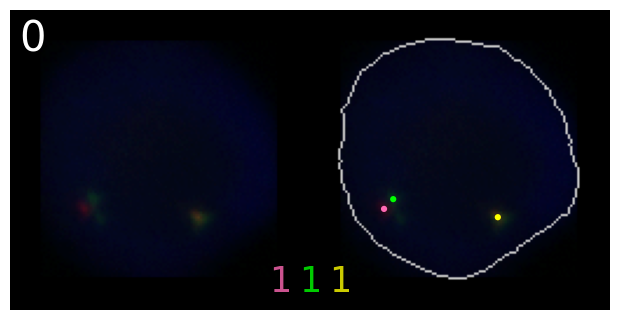

In [194]:
import cv2
def plot_cell_and_spots(img, mask, signals, colors, number):

    #enhanced_img = cv2.convertScaleAbs(img, alpha=4, beta=-8)
    enhanced_img = img

    fig, ax = plt.subplots(1, 2, figsize=(6, 3)) 
    
    ax[0].imshow(enhanced_img)
    ax[0].axis("off")
    
    bmask = mask > 0
    edges = dilation(bmask > 0, diamond(1)) & ~bmask
    img_spots = enhanced_img.copy()
    img_spots[edges] = 200 
    ax[1].imshow(img_spots)
    ax[1].axis("off")

    for name, spot in signals.items():
        if len(spot) > 0:  # check if there are spots
            ax[1].scatter(spot[:, 1], spot[:, 0], s=20, edgecolors='none', c=colors[name], label=name)
    
    channel_counts = [len(signals[channel]) for channel in colors.keys()]

    text_colors = [colors[channel] for channel in colors.keys()]
 
    text_items = [f"{count}" for _, count in zip(colors.keys(), channel_counts)]
    
    for i, (text, color) in enumerate(zip(text_items, text_colors)):
        fig.text(-0.1 + 0.1 * i, 0.15, text, color=color, fontsize=25, alpha=0.8, transform=ax[1].transAxes, ha='center', va='top')
    
    fig.text(0.03, 0.97, str(number), color='white', fontsize=30, alpha=1, transform=ax[0].transAxes, ha='left', va='top')
    
    fig.tight_layout(pad=0) 
    return fig

# plot one roi+spots in one figure
fig = plot_cell_and_spots(rois[0], masks[0], signals[0], colors={"ch1": "hotpink", "ch2": "lime", "ch1+ch2": "yellow"}, number=0)


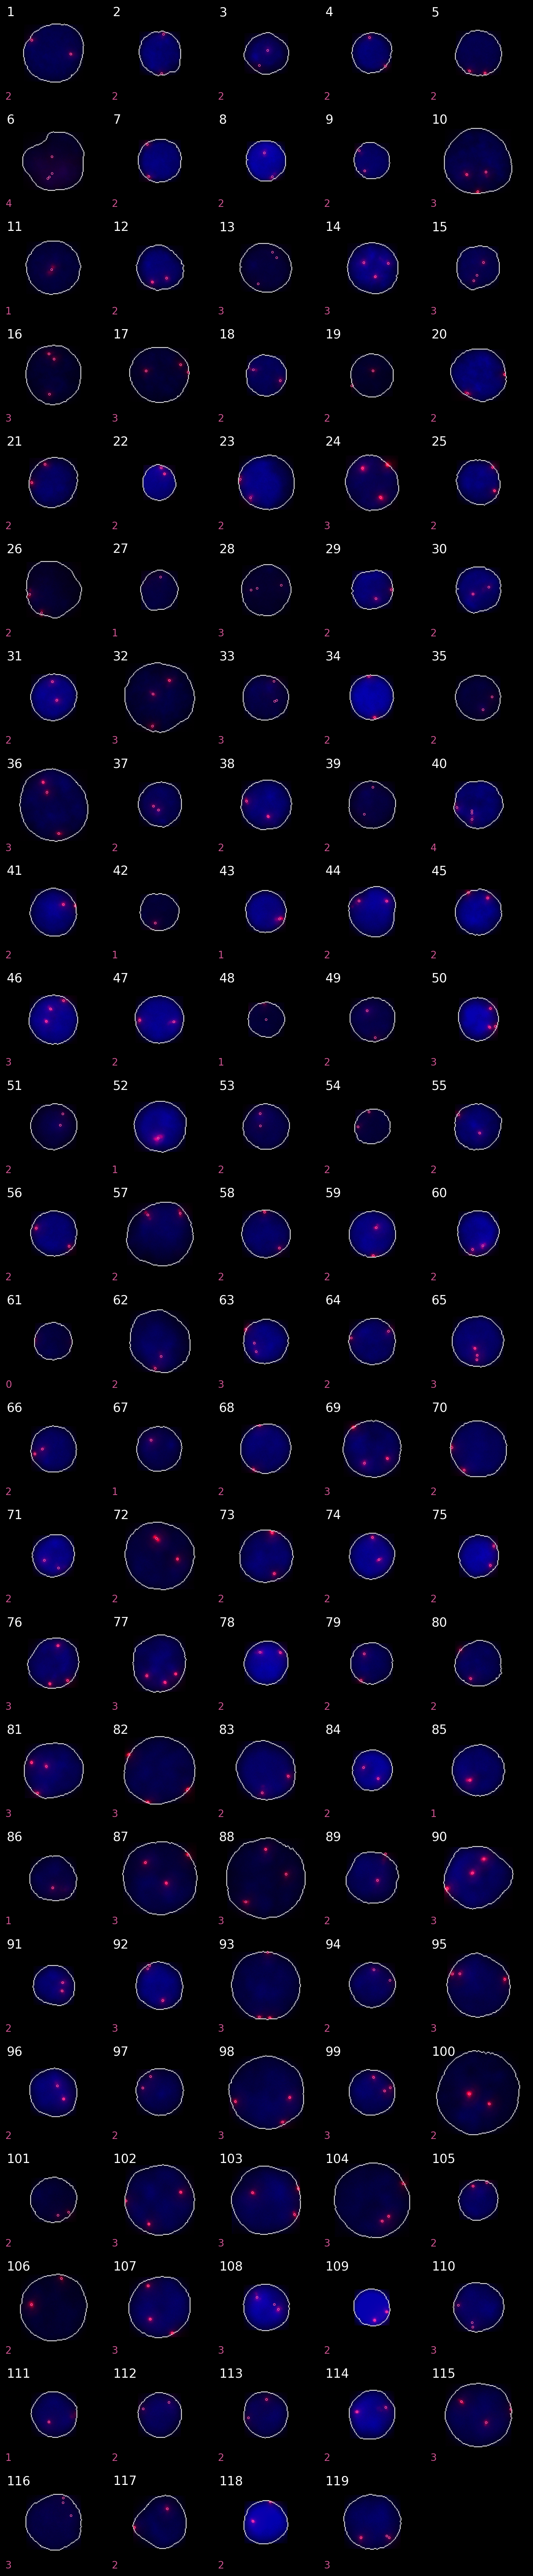

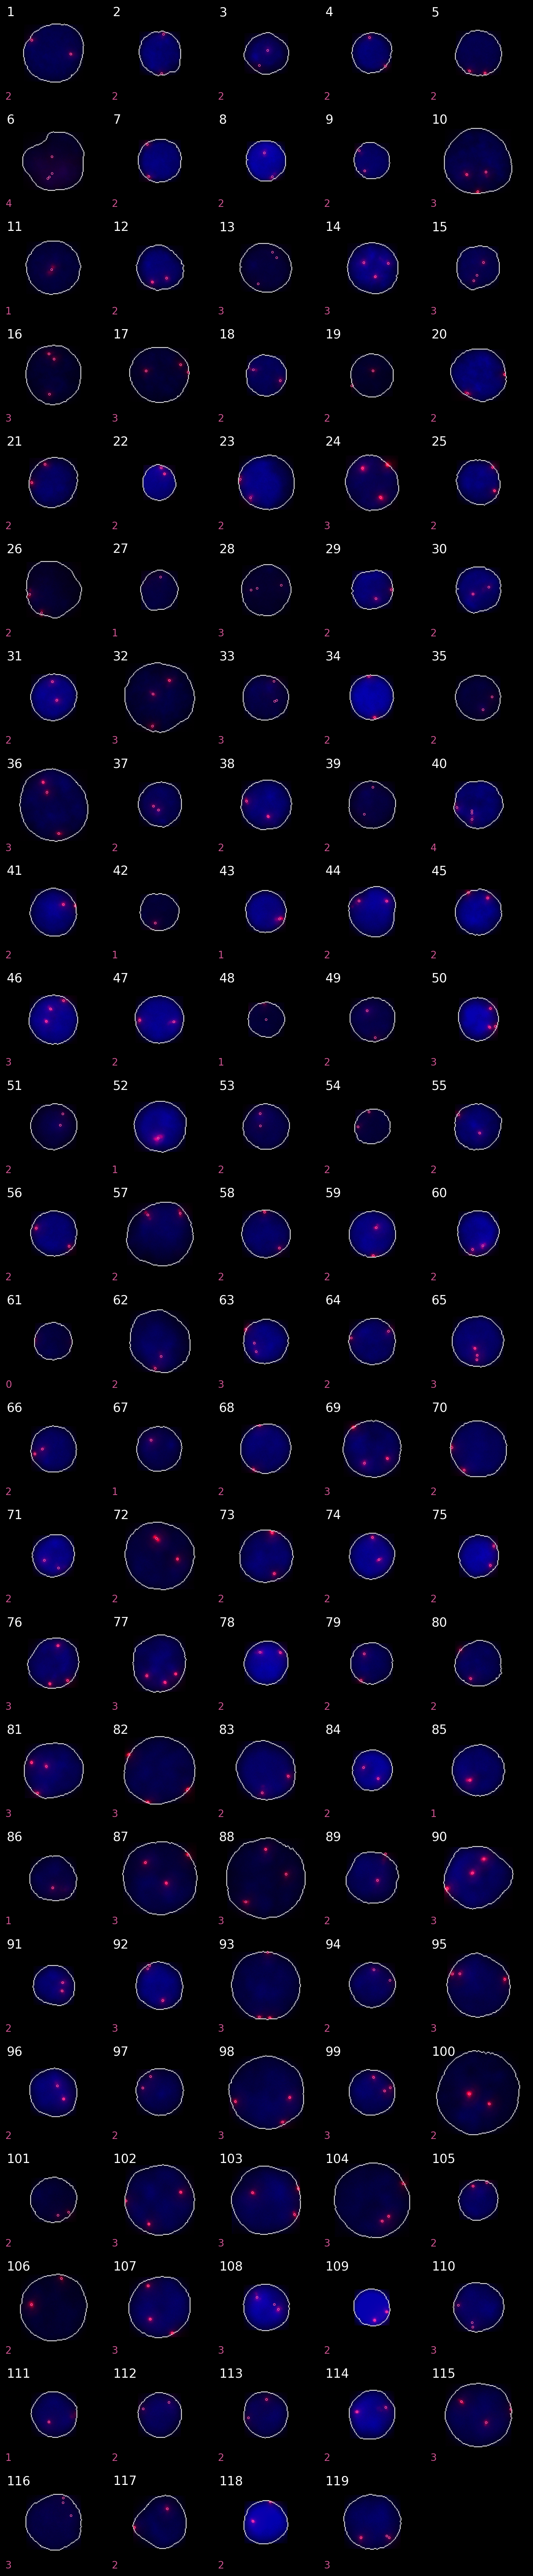

In [283]:
def plot_all_rois(rois, masks, signals, colors):
    num_plots = len(rois)
    rows = int(np.ceil(num_plots / 5))
    cols = min(5, num_plots)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3*rows), facecolor='k')

    for i, (ax, roi, mask, signal) in enumerate(zip(axs.flat, rois, masks, signals)):
        n = i+1
        bmask = mask > 0
        edges = dilation(bmask>0, diamond(1)) & ~bmask
        img = roi.copy()
        img[edges, :] = 255
        ax.imshow(img)

        for name, spot in signal.items():
            if name in colors and len(spot) > 0:
                ax.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)

        channel_names = list(signal.keys())
        channel_counts = [len(signal[channel]) for channel in channel_names]
        text_colors = [colors.get(channel, 'white') for channel in channel_names]
        text_items = [f"{count}" for count in channel_counts]

        for i, (text, color) in enumerate(zip(text_items, text_colors)):
            ax.text(0.05 + 0.1 * i, 0.12, text, color=color, fontsize=20, alpha=0.8, transform=ax.transAxes, ha='center', va='top')

        ax.text(0.03, 0.97, str(n), color='white', fontsize=25, alpha=1, transform=ax.transAxes, ha='left', va='top')
        ax.axis("off")

    for ax in axs.flat[num_plots:]:
        ax.set_facecolor('k')
        ax.axis('off')

    plt.tight_layout()
    return fig

plot_all_rois(rois, masks, signals, colors={"ch1": "hotpink", "ch2": "lime", "ch1+ch2": "yellow"})